# 분류 모델
- 분류(classification): 카테고리 구분을 예측하는 것
- 컨퓨전 매트릭스와 분류의 성능 지표인 정확도(accuracy), 정밀도(precision), 리콜(recall), f-1 점수 이해
- 오분류가 발생한 샘플 찾기
- 내부 점수 보기 (decision_function)
- 분류 경계치 (threshold)를 바꾸어 정밀도와 리콜을 다르게 선택하는 방법

# 데이터
- 남여 성별, 키, 몸무게 데이터

## import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams.update({'font.size': 15})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

## 데이터 읽기

In [3]:
data = pd.read_csv("https://github.com/data-labs/data/raw/main/weight-height.csv")
print(data.shape)
data[:5]

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


## 전처리

In [4]:
# 성별 인코딩, 단위 변환 (인치, 파운드 --> cm, kg)
data.Gender = data.Gender.map({'Male':0, 'Female':1})
data.Height = data.Height*2.54 # cm
data.Weight = data.Weight*0.453592 # kg
data[:5]

,Gender,Height,Weight
0,0,187.571423,109.720985
1,0,174.706036,73.622732
2,0,188.239668,96.497550
3,0,182.196685,99.809504
4,0,177.499761,93.598619


In [5]:
# 백업
df = data.copy()

## 데이터 탐색

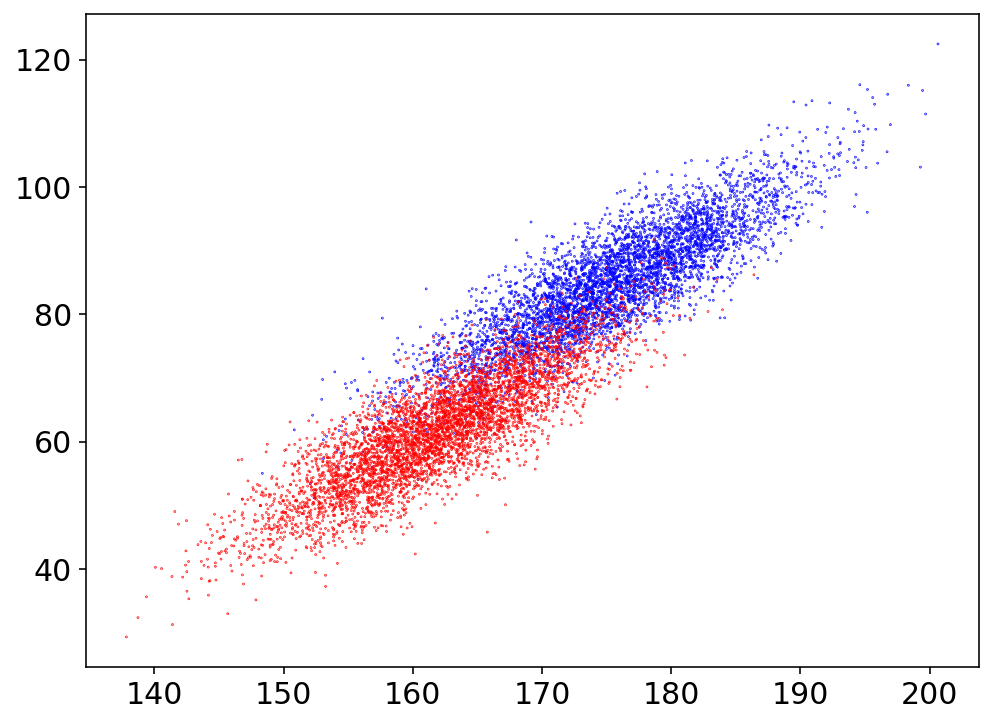

In [6]:
# 남성(0)은 파란색, 여성(1)은 붉은색
plt.scatter(df.Height,df.Weight,c=df.Gender,s=0.1, cmap='bwr')

## 데이터 나누기
- 키과 몸무게를 보고 성별를 예측하려고 함
- X: 키와 몸무게 (2개의 특성을 사용)
- y: 성별 (남여를 구분하는 이진 분류 문제)

In [7]:
X = df[["Height", "Weight"]]
y = df.Gender

## 스케일링

In [8]:
X_sc = X.copy()
scaler = StandardScaler()
X_sc.loc[:,:] = scaler.fit_transform(X_sc)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((7500, 2), (2500, 2), (7500,), (2500,))

# 선형 분류 모델

- 분류 모델에서 score함수는 정확도(accuracy)를 알려준다
- 선형 분류 모델로 SGDClassifier 사용

In [9]:
model = SGDClassifier() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련
model.score(X_test, y_test) # (3) 평가 (정확도)

0.9276

In [10]:
a1, a2, b = model.coef_[0][0], model.coef_[0][1], model.intercept_
a1, a2, b

(1.011939606529017, -4.3268065481459175, array([-0.09805685]))

## 이진 분류 결정 경계
- decision boundary
- 하나의 변수만 사용하는 경우 결정 경계: $x_{1} > b$  
- 두 개의 변수를 사용하는 경우 결정 경계: (점수) $a_{1}x_{1}+a_{2}x_{2}+b >0$  
     > $x_{2} > -$$a_{1}\over a_{2}$ $x_{1} - $$b\over{a_{2}}$


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%205.19.06.png?raw=1" width=500 align='left'>


(-3.0, 3.0)

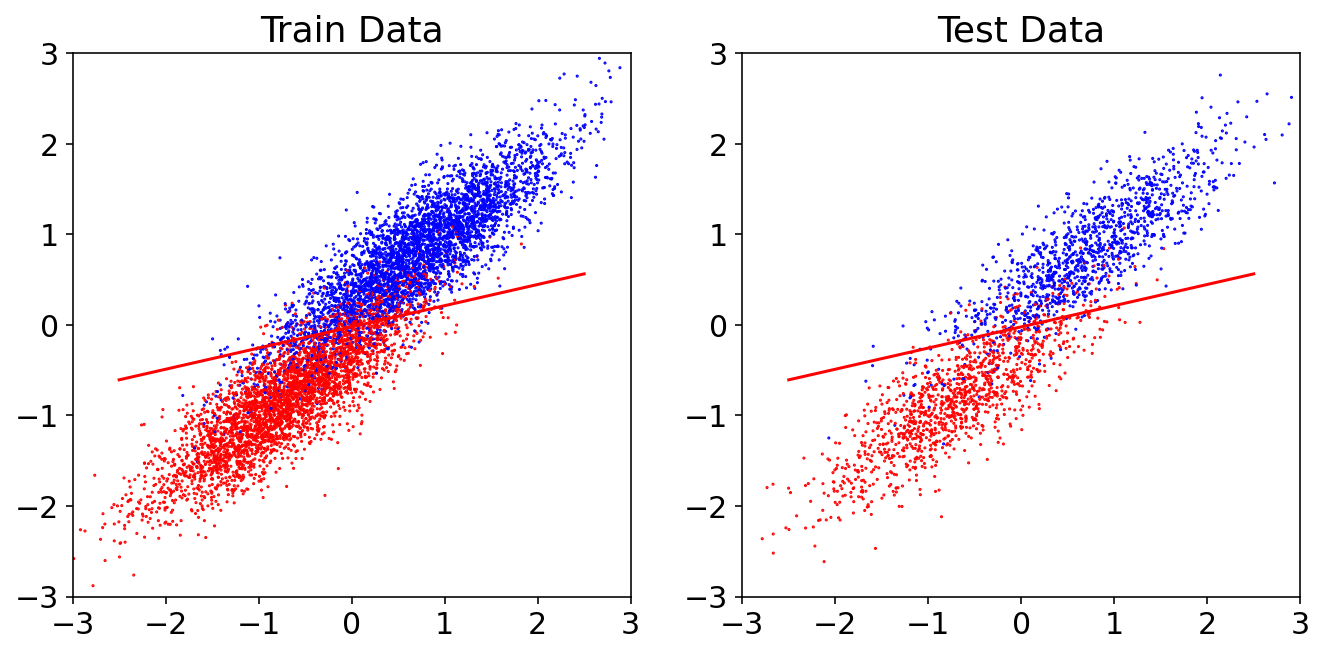

In [11]:
plt.figure(figsize=(11,5))

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2
plt.plot(xs,ys, c='r')

plt.subplot(1,2,1)  
plt.title('Train Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_train.Height,X_train.Weight, 
            c=y_train,s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.subplot(1,2,2)  
plt.title('Test Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_test.Height,X_test.Weight, 
            c=y_test, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

# 결과 보기


## 예측 결과 

In [12]:
y_pred = model.predict(X_test)
result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result[:7]

,y_test,y_pred
2528,0,0
6965,1,1
358,0,0
6288,1,1
7290,1,0
3776,0,0
3612,0,0


## 모델 사용

In [13]:
sample = [[170, 80], [166, 70], [160, 69]]
sample_sc = scaler.transform(sample)
model.predict(sample_sc)

array([0, 1, 1])

## 분류 성능 평가
- 정확도, 정밀도, 리콜, f-1 점수

In [14]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [15]:
show_clf_result(y_test, y_pred)

[[1158   74]
 [ 107 1161]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1232
           1       0.94      0.92      0.93      1268

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



# 컨퓨전 매트릭스
- 분류의 성능을 평가하려면 먼저 컨퓨전 매트릭스를 이해해야 한다

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.44.12.png?raw=1" width=450 align='left'>



##  이진 분류 예시
 - 총 100명을 진단하고 9명을 양성이라고 예측했으나 실제로 양성은 6명, 음성은 3명
 - 91명을 음성이라고 예측했으나 실제로 음성은 87명, 양성은 4명
 
<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.49.05.png?raw=1" width=450 align='left'>

## 분류 기본 성능 평가
- Accuracy (정확도): 전체 맞춘 비율 (TP+TP) / (TP+FP+FN+FP)
- Precision: positive로 예측한 것 중 실제로 맞는 비율, TP / (TP+FP) 
- Recall (Sensitivity):  전체 positive 중 모델이 찾아낸 비율, TP / (TP+FN)
- f1-score: Precision과 Recall의 조화 평균 (2 x  Precision x Recall) /  (Precision + Recall)

- Accuracy (정확도): 93/100
- Precision: 6/9
- Recall (Sensitivity):  6/10

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.56.47.png?raw=1" width = 530 align='left'>

## 10명의 환자를 검진한 결과 예

In [16]:
np.random.seed(19)
# 10명 환자에 대한 의사의 검사 점수가 아래와 같다고 배정 (랜덤)
# 점수가 클수록 암일 가능성이 높은 것임
raw_scores = np.random.randint(30,99,10)
raw_scores

array([70, 49, 82, 61, 96, 86, 52, 64, 35, 40])

In [17]:
# 환자 명단(id)과 검사 점수 
df = pd.DataFrame({"점수":raw_scores})
df

,점수
0,70
1,49
2,82
3,61
4,96
5,86
6,52
7,64
8,35
9,40


In [18]:
# 암환자를 판정하기 위해서 점수순으로 소팅 (인덱스도 같이 소팅된다)
df = df.sort_values(['점수'], ascending=False)
df

,점수
4,96
5,86
2,82
0,70
7,64
3,61
6,52
1,49
9,40
8,35


In [19]:
# 의사의 암진단은 이진분류이며 암으로 판정하는 기준 점수(threshold)를 정해야 함(65점이라고 가정)
# 암 진단 대상자 표시
threshold =  65
pred_cancer = df["점수"] > threshold
pred_cancer

4     True
5     True
2     True
0     True
7    False
3    False
6    False
1    False
9    False
8    False
Name: 점수, dtype: bool

In [20]:
# 진단 컬럼을 추가 (불리언을 숫자로 변환), 10명중 4명이 암이라고 진단함
df["진단"] = pred_cancer.astype(int)
# df["진단"] = pred_cancer*1
df

,점수,진단
4,96,1
5,86,1
2,82,1
0,70,1
7,64,0
3,61,0
6,52,0
1,49,0
9,40,0
8,35,0


### 실제 암 발생 데이터
- 위의 점수순 환자 명단에서, 실제로 암 발생 여부(ground-truth)가 아래와 같다고 가정
 - 나중에 정밀 검사를 해서 알아낸 것

In [21]:
# 실제로 암 발생 결과 (암 발생이면 1)
df['실제암발생'] = np.array([1,1,0,1,0,1,1,0,0,0])
df

,점수,진단,실제암발생
4,96,1,1
5,86,1,1
2,82,1,0
0,70,1,1
7,64,0,0
3,61,0,1
6,52,0,1
1,49,0,0
9,40,0,0
8,35,0,0


### 컨퓨전 매트릭스와 기본 성능 평가

In [22]:
# 예측치와 실제값
y_pred = df['진단']
y_test = df['실제암발생']

In [23]:
show_clf_result(y_test, y_pred)

[[4 1]
 [2 3]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



### 주의! 컴퓨터는 0, 1 순으로 매트릭스를 표현
- 편의상 positive를 1로 표현하고 매트릭스의 (0, 0) 위치에 기록하는 경우가 많으나 컴퓨터가 생성하는 매트릭스는 우-하 단이 1인 것에 주의해야 함

- Accuracy (정확도): 전체 맞춘 비율
- Precision: positive로 예측한 것중 실제로 맞는 비율, TP / ( TP + FP ) 
- Recall (Sensitivity):  전체 positive 중 모델이 찾아낸 비율, TP / (TP+FN)
- f1-score: Precision과 Recall의 조화 평균 (2 x  Precision x Recall ) /  (Precision + Recall)

- support는 분석에 사용된 샘플수
- macro 평균은 성능평가 점수들을 0, 1 케이스에 대해서 1:1로 산술평균을 구한 것
- weighted 평균은 샘플의 갯수를 고려하여 0, 1 케이스에 대해서 가중평균을 구한 것

### (참고) 조화평균
- f-1 점수는 정밀도와 리콜의 조화평균(harmonic average)이다

- 점수들이 조화로울수록 (서로 차이가 작을수록) 조화평균 점수가 높다

- a, b의 산술 평균, $c = $${(a + b)}\over {2}$
- a, b의 조화 평균 $c$, ${1}\over{c}$ =  ($1\over{a}$+${1}\over{b}$) $/ 2$   
> $c = $ ${2ab}\over{(a+b)}$

In [24]:
# 예: 학생 4명의 국어, 수학 성적
df1 = pd.DataFrame({"국어": [20, 30, 80, 60], "수학": [100, 90, 40, 60]})
df1

,국어,수학
0,20,100
1,30,90
2,80,40
3,60,60


In [25]:
# 산술평균과 조화평균을 비교
# 산술평균(arithmetic average)은 조화를 측정하지 못한다

df1["산술평균"] = (df1['국어']+df1['수학'])/2
df1["조화평균"] = 2*df1['국어']*df1['수학']/(df1['국어']+df1['수학'])
df1.round(1)

,국어,수학,산술평균,조화평균
0,20,100,60.0,33.3
1,30,90,60.0,45.0
2,80,40,60.0,53.3
3,60,60,60.0,60.0


# 성별 분류 문제 다시 보기

In [26]:
df = data.copy()
X = df[["Height", "Weight"]]
y = df.Gender
X_sc = X.copy()
scaler = StandardScaler()
X_sc.loc[:,:] = scaler.fit_transform(X_sc)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y)
model = SGDClassifier() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련
model.score(X_test, y_test) # (3) 평가 (정확도)

0.9184

In [27]:
y_pred = model.predict(X_test)
show_clf_result(y_test, y_pred)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



In [28]:
a1, a2, b = model.coef_[0][0], model.coef_[0][1], model.intercept_

(-3.0, 3.0)

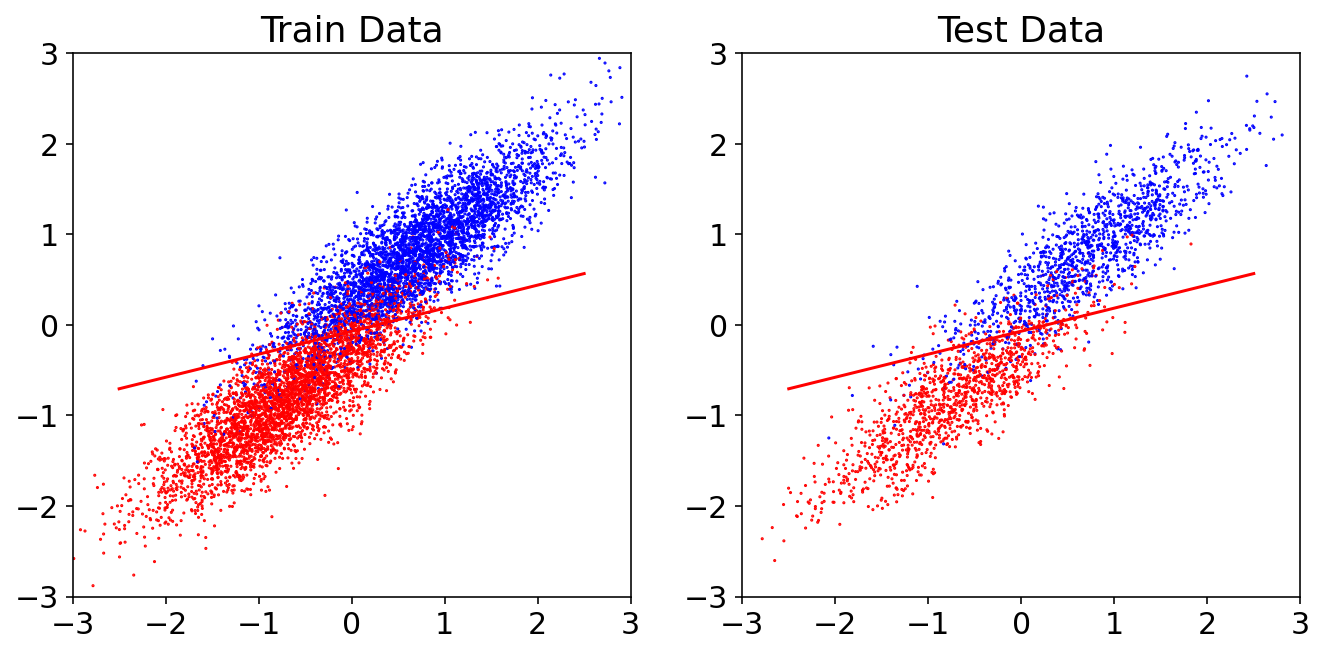

In [29]:
plt.figure(figsize=(11,5))

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2

plt.subplot(1,2,1)  
plt.title('Train Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_train.Height,X_train.Weight, c=y_train, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.subplot(1,2,2)  
plt.title('Test Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_test.Height,X_test.Weight, c=y_test, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

## 잘못 분류된 샘플 찾기
- 힌트: 잘목 분류된 샘플의 인덱스를 먼저 구한다
- 해당 샘플들만 산포도에 그린다

In [30]:
y_pred = model.predict(X_test)
index_false = X_test[y_pred != y_test].index
index_false

Int64Index([6744, 8634, 6434, 8310,  517, 5344,  134, 2352, 8978, 7358,
            ...
            1403, 9539,   24, 3833, 4405, 4402, 5860, 2723, 9275, 8348],
           dtype='int64', length=204)

In [31]:
df_false = pd.concat((X_test.loc[index_false],y_test.loc[index_false]),axis=1)
df_false[:5]

,Height,Weight,Gender
6744,-1.162488,-0.248375,1
8634,0.232437,0.026947,1
6434,-0.604047,0.121036,1
8310,0.897939,0.411969,1
517,-0.132939,-0.128412,0


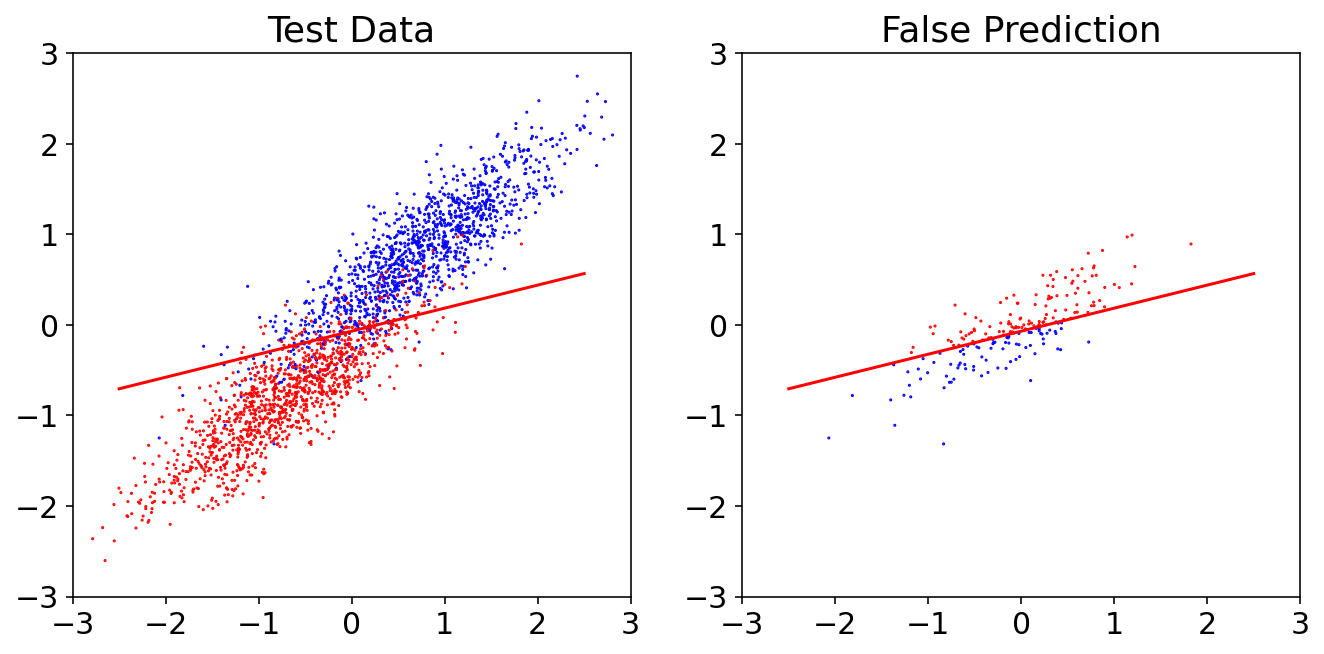

In [32]:
plt.figure(figsize=(11,5))

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2

plt.subplot(1,2,1)  
plt.title('Test Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_test.Height,X_test.Weight, c=y_test, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.subplot(1,2,2)  
plt.title('False Prediction')
plt.plot(xs,ys, c='r')
plt.scatter(df_false.Height,df_false.Weight, c=df_false.Gender, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.show()

## (연습) 남성을 여성으로 잘 못 분류한 샘플 찾기
- 0을 1로 오분류한 경우 찾기이므로 y_test=0, y_pred=1인 경우를 찾으면 됨
- y_test < y_pred 

In [116]:
# (풀이)



## (연습) 여성을 남성으로 잘 못 분류한 샘플 찾기
- 1을 0로 오분류한 경우 찾기이므로 y_test=1, y_pred=0인 경우를 찾으면 됨

In [117]:
# (풀이)



## 분류 점수

- 분류를 수행하기 위해서 내부적으로 계산하는 점수(score)
> score: $a_{1}x_{1}+a_{2}x_{2}+b >0$  
     
- 점수를 제공하는 모델: 선형모델, SVM
 - 각 샘플별 점수는 decision_function()으로 얻는다
- 확률을 사용하는 모델: 트리계열, 랜덤포레스트, 부스팅, 로지스틱회귀, 신경망
 - 각 샘플별 분류 확률은 predict_proba()으로 얻는다

In [63]:
score = model.decision_function(X_test) 
score

array([-4.94368197, -3.63951309, -4.21365805, ...,  1.0728945 ,
        2.98813113, -0.06881786])

In [64]:
df = X_test.copy()
df["score"] = score
df

,Height,Weight,score
1044,0.860749,1.304291,-4.943682
2869,1.716181,1.216886,-3.639513
3984,1.112741,1.197683,-4.213658
8652,-1.697673,-1.811901,5.601974
6,0.628362,0.700397,-2.613534
...,...,...,...
8879,-0.452691,-0.514377,1.406401
4801,1.494942,1.372009,-4.543591
9735,0.084297,-0.299857,1.072895
6430,-0.546821,-0.908131,2.988131


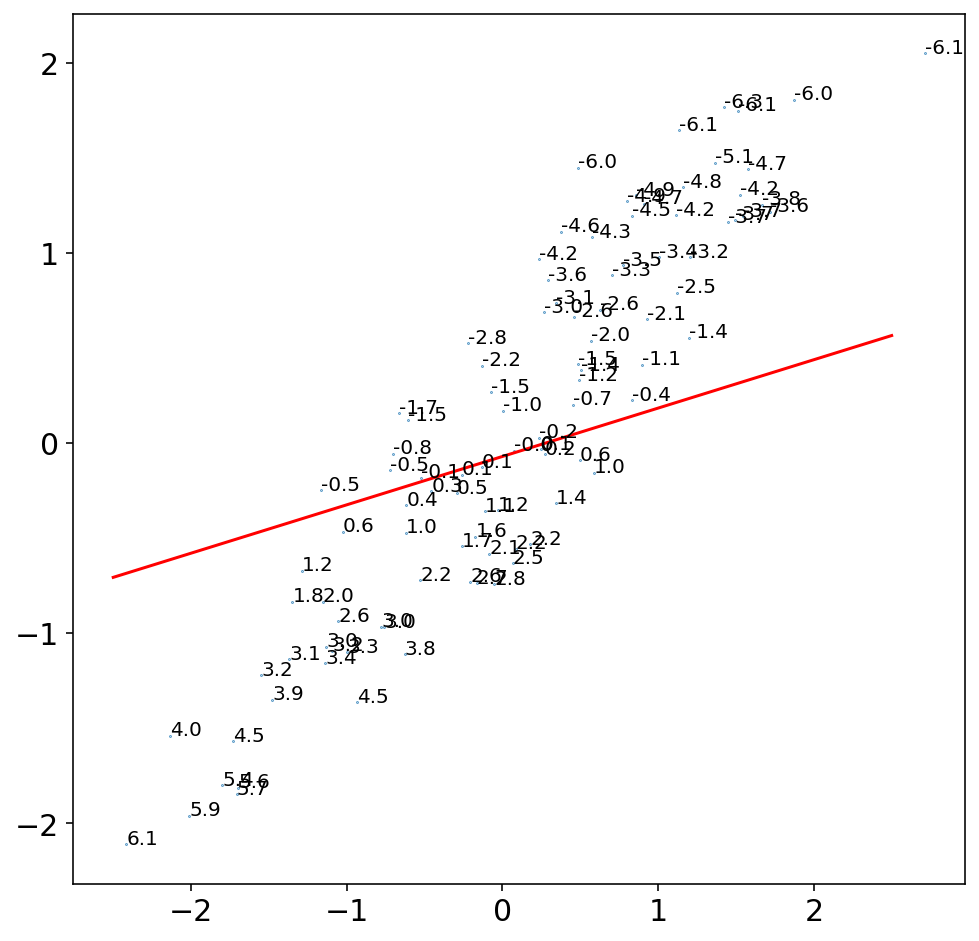

In [65]:
# N개의 테스트 샘플만 관찰하겠다
# 점수는 소수점 1자리만 출력한다

N = 100
plt.figure(figsize=(8,8))
xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2
plt.plot(xs,ys, c='r')

plt.scatter(df[:N].Height,df[:N].Weight, s=0.1)

for i in range(N):
    plt.text(df[:N].Height.iloc[i],df[:N].Weight.iloc[i], 
             df[:N].score.values.round(1).astype(str)[i],
             fontsize=10)

# 분류 경계값 바꾸기

In [41]:
df.sort_values('score')

,Height,Weight,score
1506,2.425330,2.744751,-9.403019
3285,3.160798,2.879407,-9.179082
3090,2.013015,2.473348,-8.690633
3918,2.643284,2.548590,-8.326988
1154,1.882972,2.346547,-8.289727
...,...,...,...
8620,-2.319100,-2.243119,6.770477
7215,-0.952331,-1.906309,6.816370
5191,-1.950944,-2.202391,6.996672
5026,-2.552308,-2.384796,7.122804


- 머신러닝 모델은 기본적으로 f1 점수가 가장 큰 곳을 찾으며 이를 만족하는 점수(threshold)가 0이다.

In [42]:
show_clf_result(y_test, y_pred)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



- 기본 모델의 동작 확인: 점수 > 0 를 기준으로 분류 예측을 하고 성능을 평가한다

In [66]:
y_pred_org = score > 0
y_pred_org[:5]

array([False, False, False,  True, False])

In [67]:
show_clf_result(y_test, y_pred_org)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



## 0.92보다 높은 높은 리콜을 갖는 모델 사용하기

- 높은 리콜을 얻는 분류예측 모델을 만드는 방법은 경계값을 0보다 낮게 잡으면 된다

In [77]:
y_pred_high_recall = score > -1
show_clf_result(y_test, y_pred_high_recall)

[[1055  203]
 [  46 1196]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      1258
           1       0.85      0.96      0.91      1242

    accuracy                           0.90      2500
   macro avg       0.91      0.90      0.90      2500
weighted avg       0.91      0.90      0.90      2500



- 새로운 샘플에 대해서 기본 모델을 사용하는 경우의 예측 (여성:1)

In [78]:
sample = [[180, 80], [166, 70], [160, 69]]
sample_sc = scaler.transform(sample)
model.predict(sample_sc)

array([0, 1, 0])

- 새로운 샘플에 대해서 리콜을 높인 모델을 사용하는 경우의 예측

In [80]:
(model.decision_function(sample_sc) > -1)*1

array([0, 1, 1])

## (연습) 높은 정밀도를 갖는 예측 모델을 만드시오

In [118]:
# (풀이)



## 경계값을 높은순으로 바꾸면서 정밀도-리콜 계산하기
- 경계치를 높은값에서 낮은 값으로 조금씩 바꾸면서 정밀도, 리콜의 변화를 그래프로 그린다

In [92]:
score.min(), score.max()

(-9.403019061084668, 7.944164367412942)

In [93]:
threshold_range = np.linspace(score.max(), score.min(), 100)
threshold_range = threshold_range[1:] 
# 최대값보다 큰 샘플은 없으므로 최대값은 삭제
threshold_range[:5]

array([7.76894029, 7.59371622, 7.41849214, 7.24326807, 7.06804399])

In [98]:
result = []
for thres in list(threshold_range):
    y_pred_i = score > thres
    result.append((thres, precision_score(y_test, y_pred_i), recall_score(y_test, y_pred_i)))

<AxesSubplot:xlabel='threshold'>

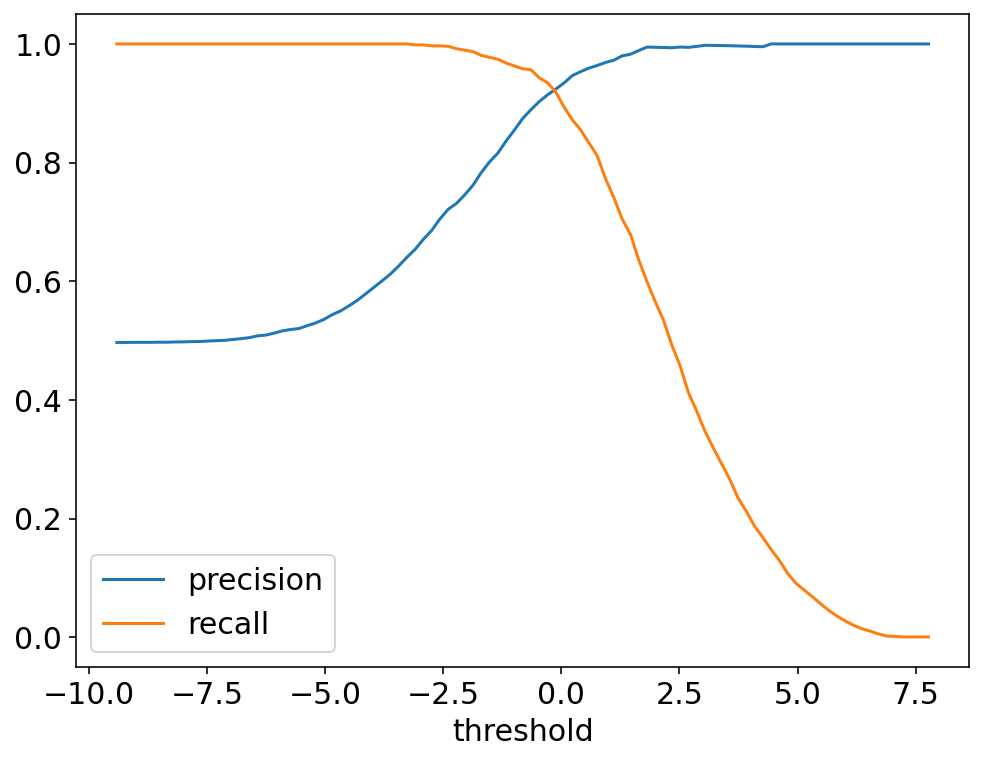

In [99]:
df_r = pd.DataFrame(result, columns=['threshold','precision', 'recall'])
df_r.set_index('threshold').plot()

## (연습) 가로축을 리콜, 세로축을 정밀도로 precicion-recall curve를 그린다

In [119]:
# (풀이)



## (연습) 리콜이 0.95가 되는 경계값을 찾아보시오
- 이 조건을 만족하는 예측 모델을 만드시오

In [120]:
# (풀이)



## 임의의 경계값을 갖는 예측 모델 정의

In [108]:
def new_model(model, thres, X_test):
    return (model.decision_function(X_test) > thres)*1

In [111]:
new_y_pred = new_model(model, -0.64, X_test)
new_y_pred[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

## (연습) 위의 new_model()를 이용해서 기본 모델을 만드시오
- 기본 모델이란 컴퓨터가 기본으로 만들어주는 예측 모델을 말한다
- 성능을 평가하여 확인한다

In [121]:
# (풀이)



# 정답

## (연습) 남성을 여성으로 잘 못 분류한 샘플 찾기
- 0을 1로 오분류한 경우 찾기이므로 y_test=0, y_pred=1인 경우를 찾으면 됨
- y_test < y_pred 

In [33]:
index_false_man = X_test[y_test < y_pred].index
print(index_false_man.size)

83


In [34]:
df_false = pd.concat((X_test.loc[index_false_man],
                      y_test.loc[index_false_man]),axis=1)
df_false[:5]

,Height,Weight,Gender
517,-0.132939,-0.128412,0
134,-0.618515,-0.325828,0
2352,-0.455792,-0.254125,0
2192,0.430870,-0.042205,0
3376,-0.115041,-0.406578,0


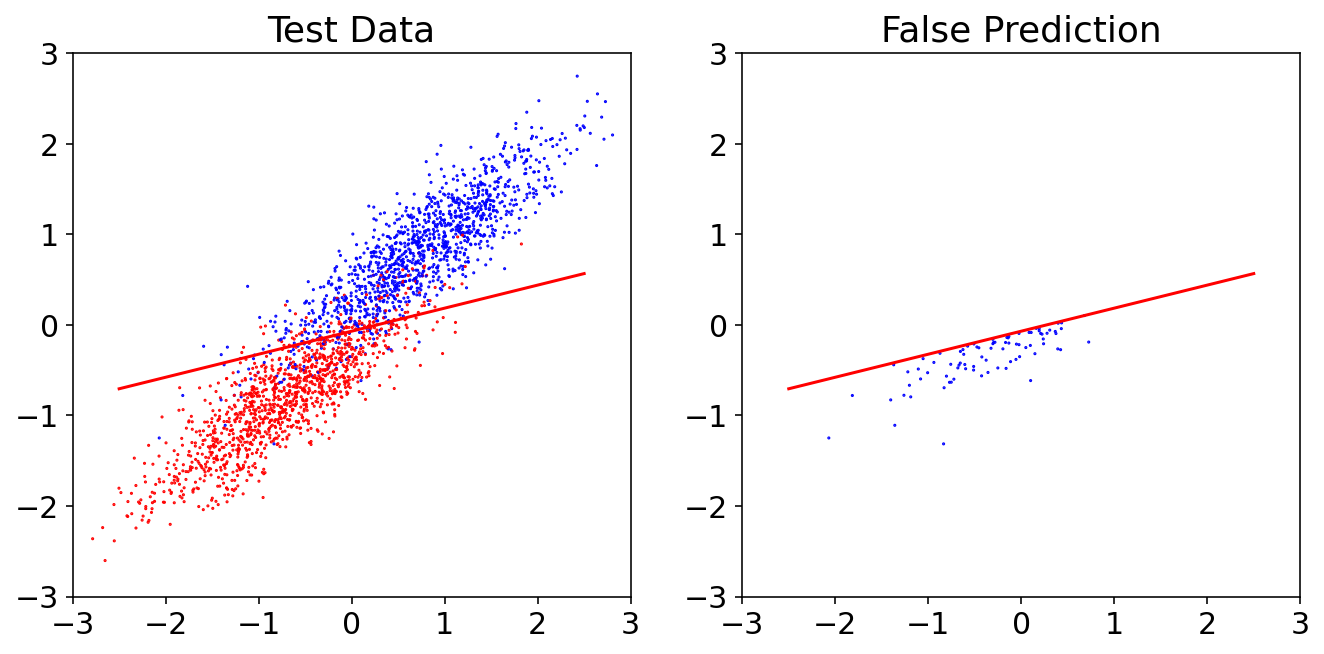

In [35]:
plt.figure(figsize=(11,5))

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2

plt.subplot(1,2,1)  
plt.title('Test Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_test.Height,X_test.Weight, c=y_test, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.subplot(1,2,2)  
plt.title('False Prediction')
plt.plot(xs,ys, c='r')
plt.scatter(df_false.Height,df_false.Weight, c=df_false.Gender, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.show()

## (연습) 여성을 남성으로 잘 못 분류한 샘플 찾기
- 1을 0로 오분류한 경우 찾기이므로 y_test=1, y_pred=0인 경우를 찾으면 됨

In [36]:
index_false_woman = X_test[y_test > y_pred].index
print(index_false_woman.size)
df_false = pd.concat((X_test.loc[index_false_woman],
                      y_test.loc[index_false_woman]),axis=1)
df_false.loc[index_false_woman[:5]]

121


,Height,Weight,Gender
6744,-1.162488,-0.248375,1
8634,0.232437,0.026947,1
6434,-0.604047,0.121036,1
8310,0.897939,0.411969,1
5344,-0.520890,-0.182729,1


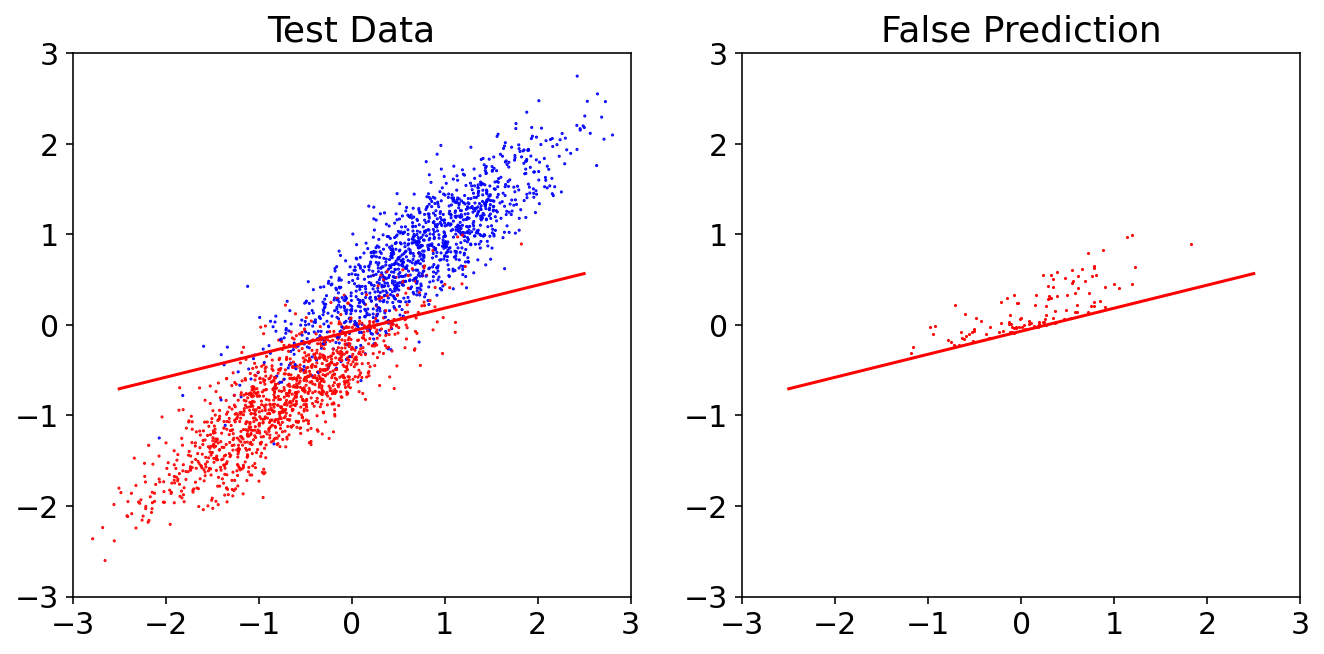

In [62]:
df_false = pd.concat((X_test.loc[index_false_woman],
                      y_test.loc[index_false_woman]),axis=1)

plt.figure(figsize=(11,5))

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2

plt.subplot(1,2,1)  
plt.title('Test Data')
plt.plot(xs,ys, c='r')
plt.scatter(X_test.Height,X_test.Weight, c=y_test, s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.subplot(1,2,2)  
plt.title('False Prediction')
plt.plot(xs,ys, c='r')
plt.scatter(df_false.Height,df_false.Weight, c='r', s=0.3,cmap='bwr')
plt.ylim([-3,3])
plt.xlim([-3,3])

plt.show()

## (연습) 높은 정밀도를 갖는 예측 모델을 만드시오

In [81]:
y_pred_high_precision = score > 1
show_clf_result(y_test, y_pred_high_precision)

[[1229   29]
 [ 300  942]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1258
           1       0.97      0.76      0.85      1242

    accuracy                           0.87      2500
   macro avg       0.89      0.87      0.87      2500
weighted avg       0.89      0.87      0.87      2500



## (연습) 가로축을 리콜, 세로축을 정밀도로 precicion-recall curve를 그린다

<AxesSubplot:xlabel='threshold'>

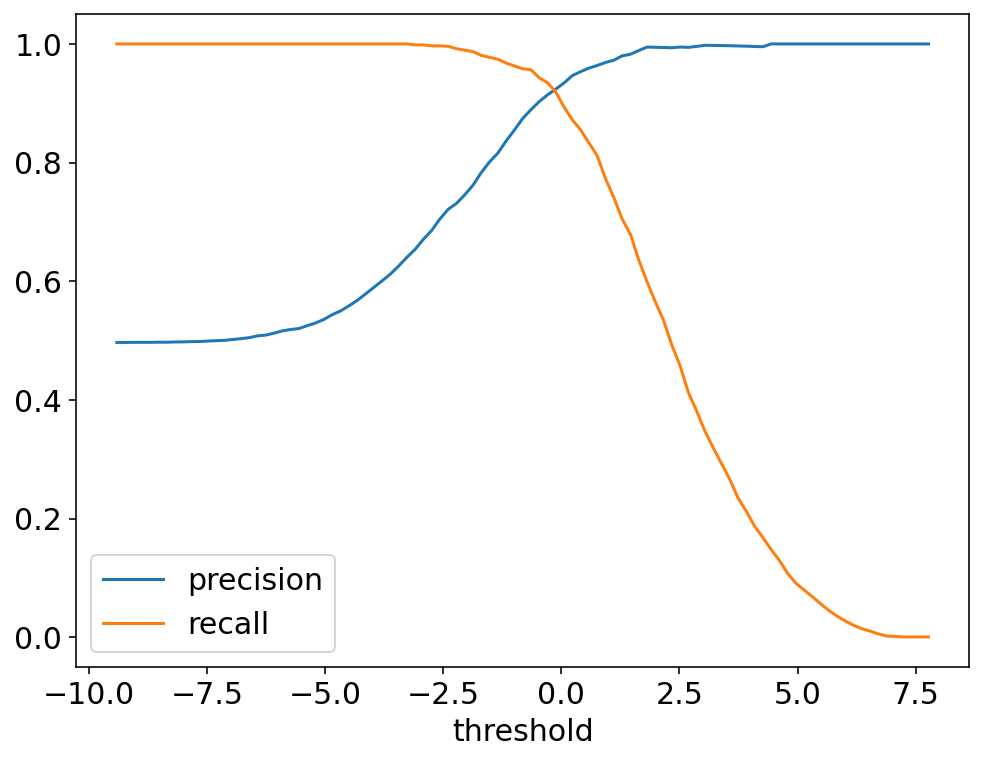

In [126]:
score.min(), score.max()

threshold_range = np.linspace(score.max(), score.min(), 100)
threshold_range = threshold_range[1:] 

result = []
for thres in list(threshold_range):
    y_pred_i = score > thres
    result.append((thres, precision_score(y_test, y_pred_i), recall_score(y_test, y_pred_i)))

df_r = pd.DataFrame(result, columns=['threshold','precision', 'recall'])
df_r.set_index('threshold').plot()

Text(0, 0.5, 'precision')

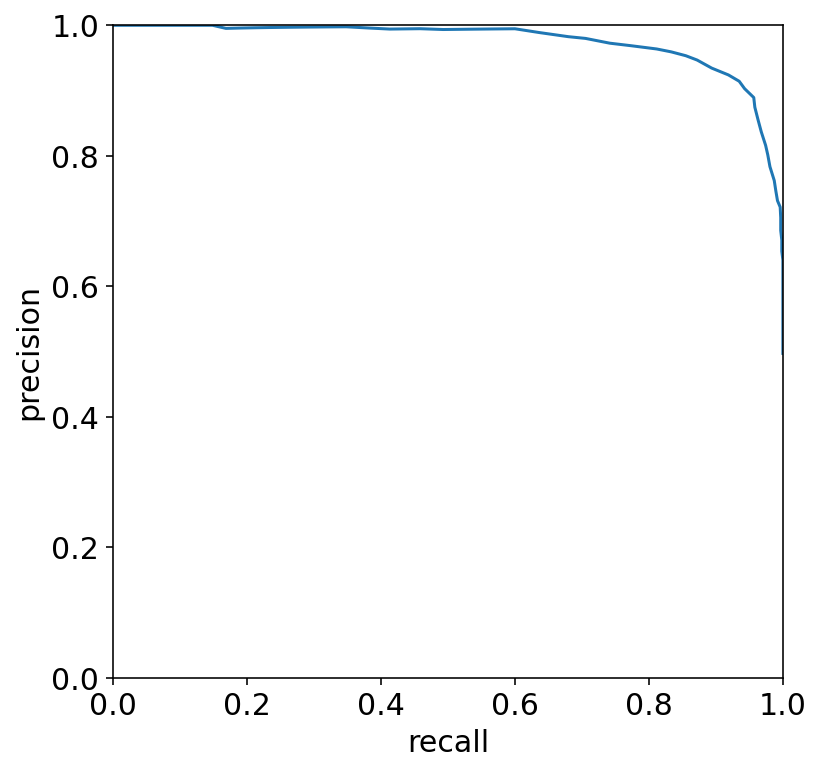

In [127]:
plt.figure(figsize=(6,6))

plt.plot(df_r.recall, df_r.precision)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("recall")
plt.ylabel("precision")

## (연습) 리콜이 0.95가 되는 경계값을 찾아보시오
- 이 조건을 만족하는 예측 모델을 만드시오

In [104]:
df_r[40:60]

,threshold,precision,recall
40,0.759977,0.963671,0.811594
41,0.584753,0.959222,0.833333
42,0.409529,0.953321,0.855072
43,0.234305,0.946678,0.871981
44,0.059081,0.934343,0.893720
45,-0.116143,0.923887,0.918680
46,-0.291367,0.914173,0.934783
47,-0.466591,0.902853,0.942834
48,-0.641815,0.889222,0.956522
49,-0.817039,0.874357,0.958132


In [114]:
new_y_pred = (model.decision_function(X_test) > -0.64)*1
new_y_pred[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

## (연습) 위의 new_model()를 이용해서 기본 모델을 만드시오
- 기본 모델이란 컴퓨터가 기본으로 만들어주는 예측 모델을 말한다
- 성능을 평가하여 확인한다

In [115]:
new_y_pred = new_model(model, 0, X_test)
show_clf_result(y_test, y_pred)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500

